In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime

In [2]:
data = pd.read_csv("A:/Programming/Python/NLP/Data files/Time_serires_analysis_data/AirPassengers.csv")
data.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [3]:
data['Month'] = pd.to_datetime(data.Month)
data = data.set_index(data.Month)
data.drop('Month', axis=1, inplace=True)

In [4]:
data.head(10)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [5]:
data.dtypes

#Passengers    int64
dtype: object

In [6]:
ts = data['#Passengers']
ts.head(144)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, Length: 144, dtype: int64

In [7]:
ts['1960']

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64

In [8]:
rcParams['figure.figsize'] = 15, 6

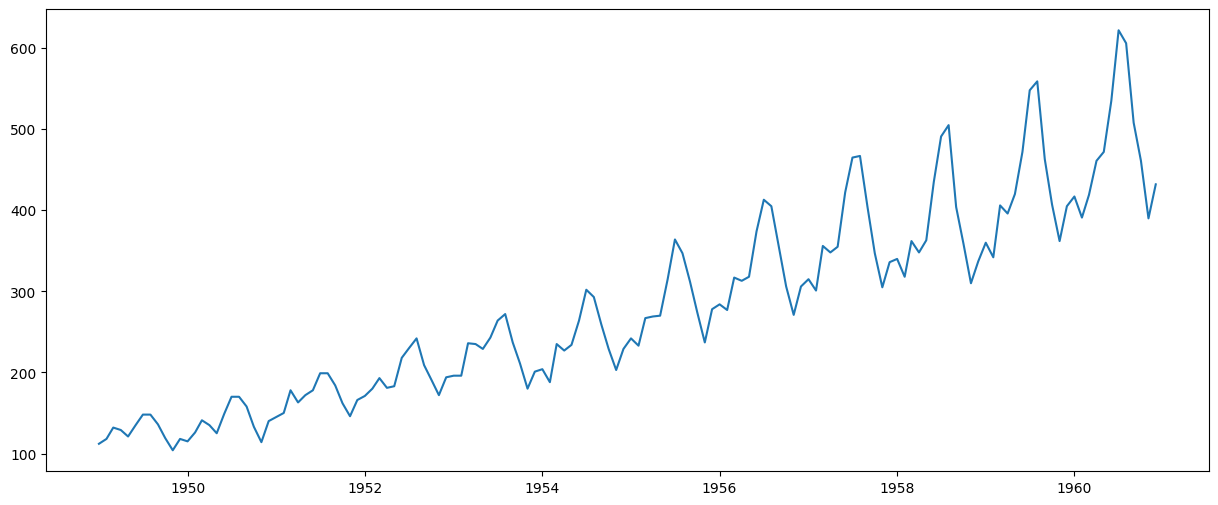

In [9]:
plt.plot(ts)

<Axes: ylabel='Density'>

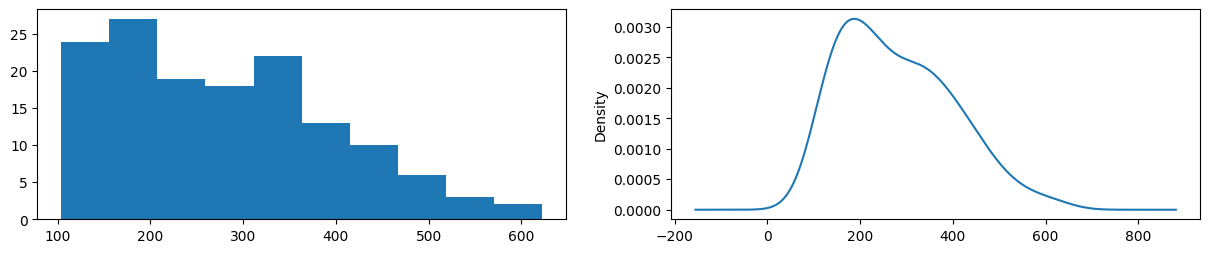

In [10]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind='kde')

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    rollmean = timeseries.rolling(window=12).mean()
    rollstd = timeseries.rolling(window=12).std()
    orig = plt.plot(timeseries, color='blue', label='original')
    mean_plt = plt.plot(rollmean, color='red', label='rolling mean')
    std_plt = plt.plot(rollstd, color='black', label='rolling std')
    plt.legend(loc='best')
    plt.title("Rolling mean and Rolling Standard deviation")
    plt.show()
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput["Critical value (%s)"%key] = value
    print(dfoutput)

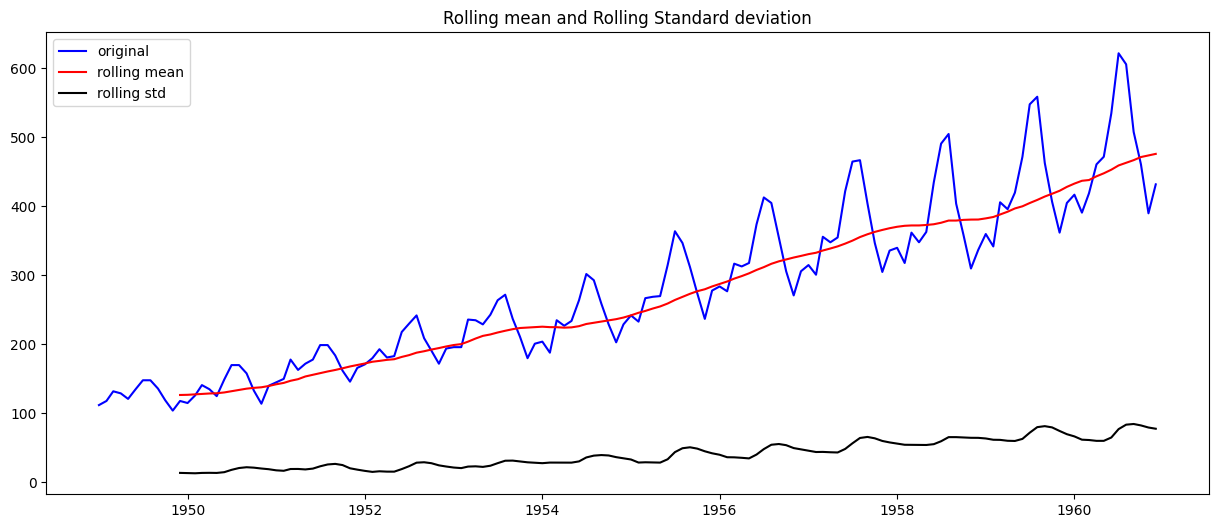

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(ts)

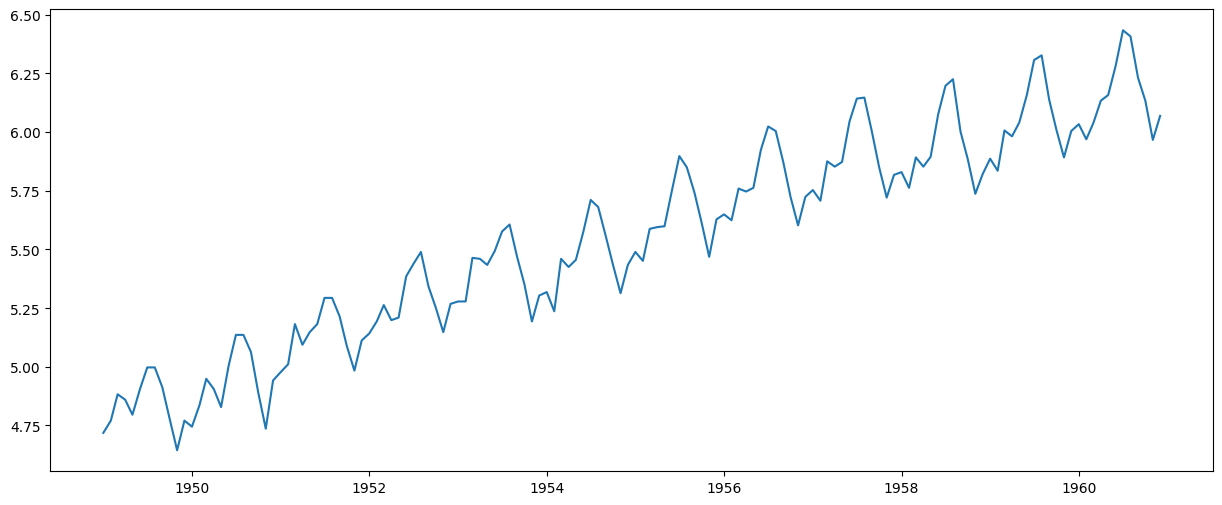

In [13]:
#We will eliminate trend by taking log transform and then smoothing

ts_log = np.log(ts)
plt.plot(ts_log)

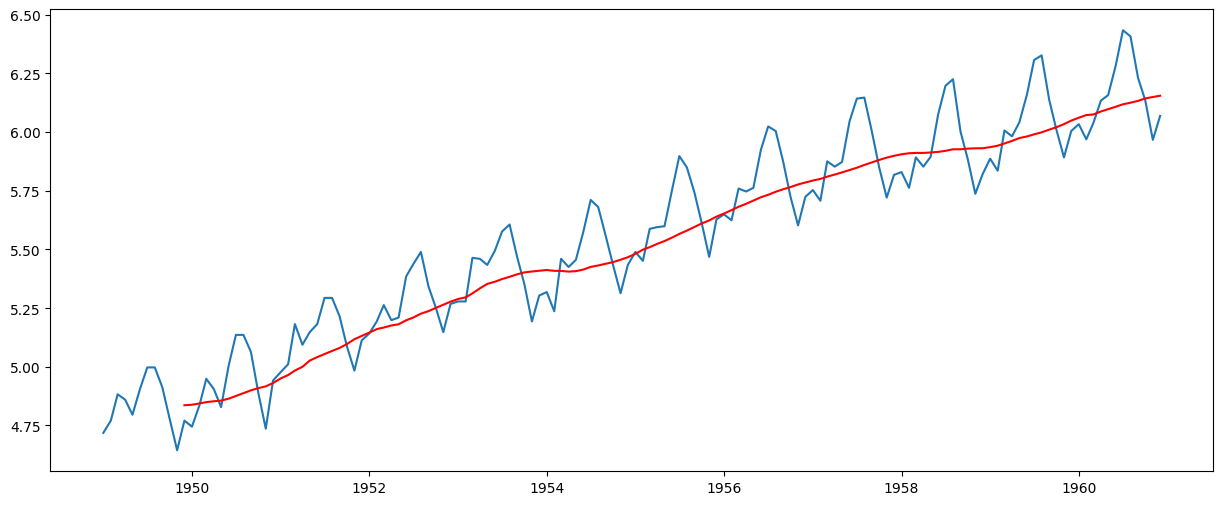

In [14]:
moving_average = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_average, color='red')

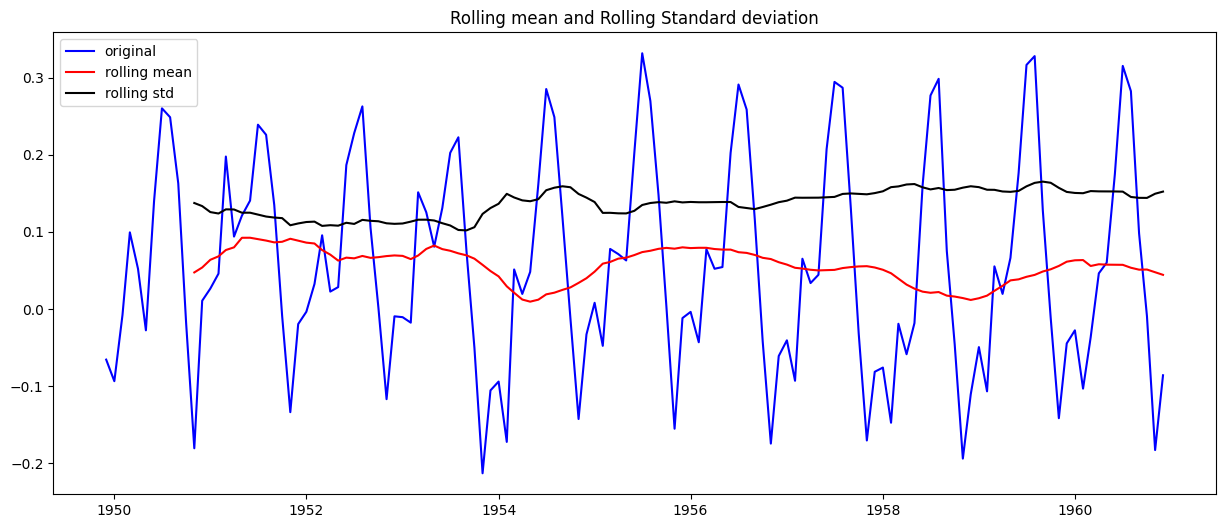

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


In [15]:
ts_log_mov_avg_dif = ts_log - moving_average
ts_log_mov_avg_dif.dropna(inplace=True)
test_stationarity(ts_log_mov_avg_dif)

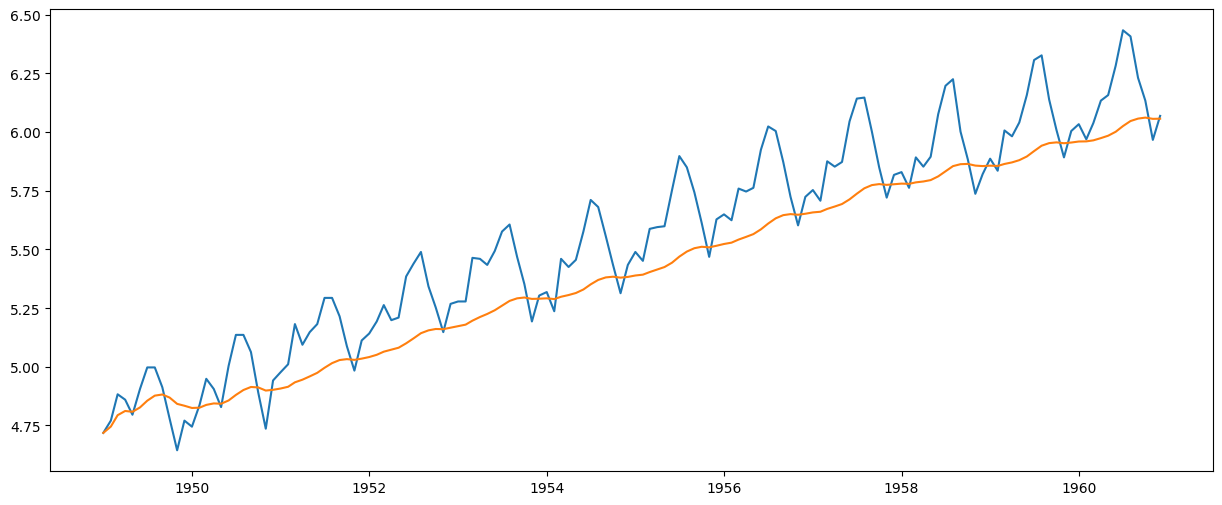

In [16]:
#exponential weighted moving average
ewm_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(ewm_avg)

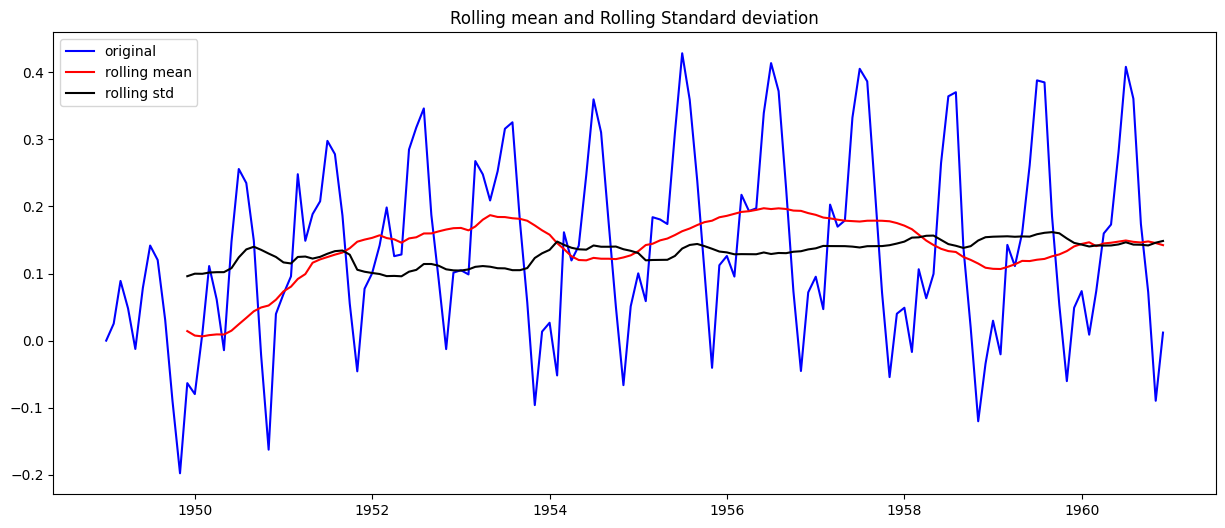

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [17]:
ts_log_ewm_diff = ts_log - ewm_avg
ts_log_ewm_diff.dropna(inplace=True)
test_stationarity(ts_log_ewm_diff)

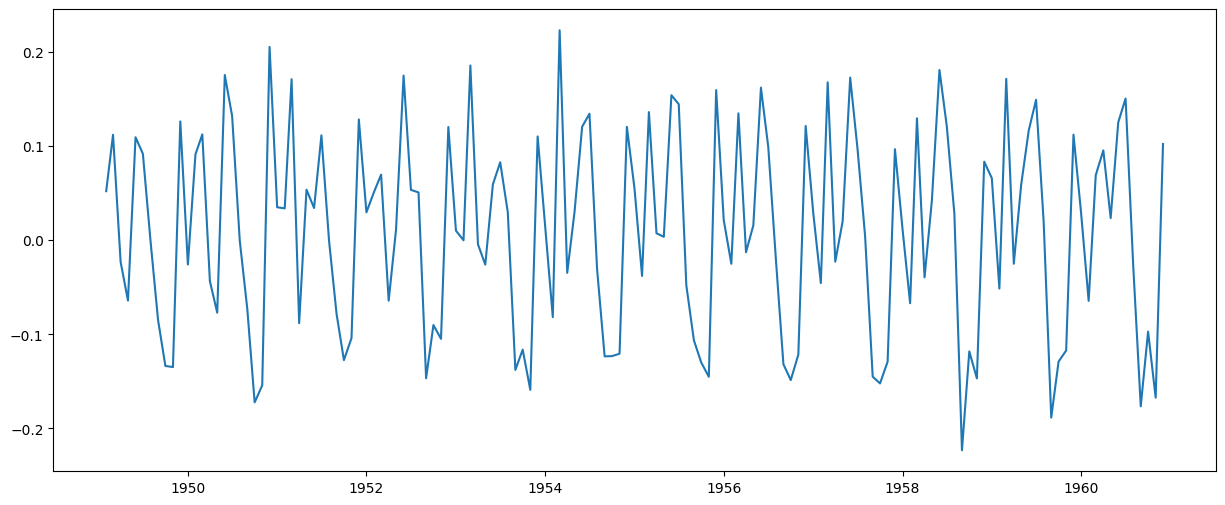

In [18]:
#eliminating trend and seosonality
#differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

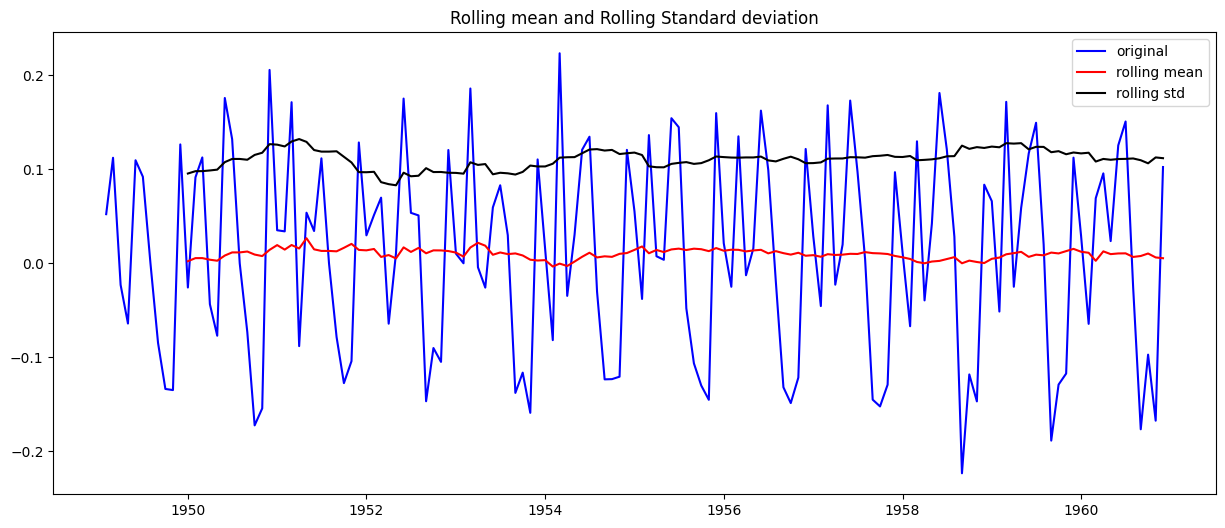

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


In [19]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

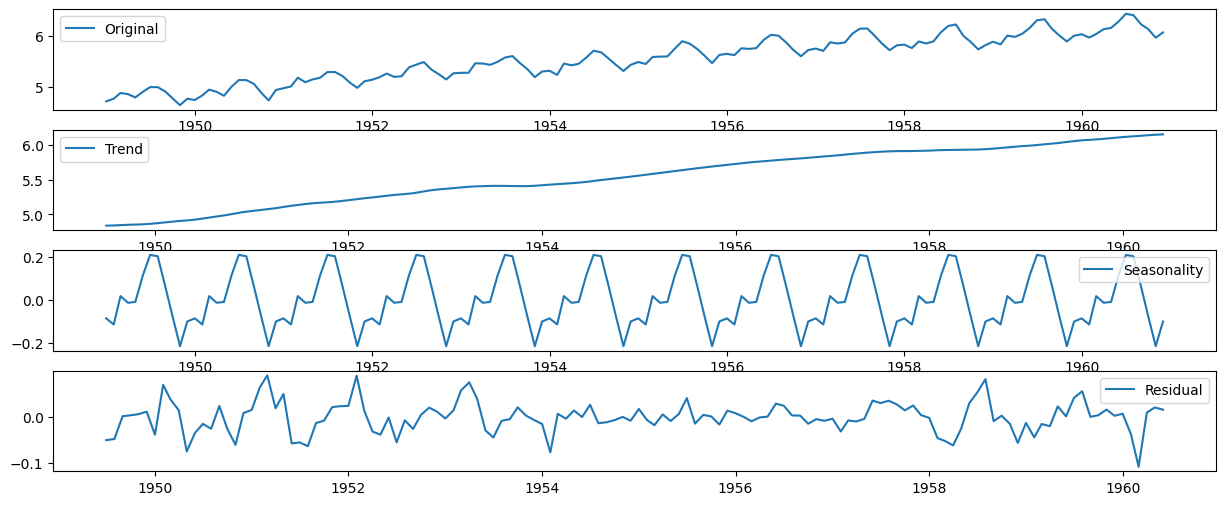

In [20]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(ts_log)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

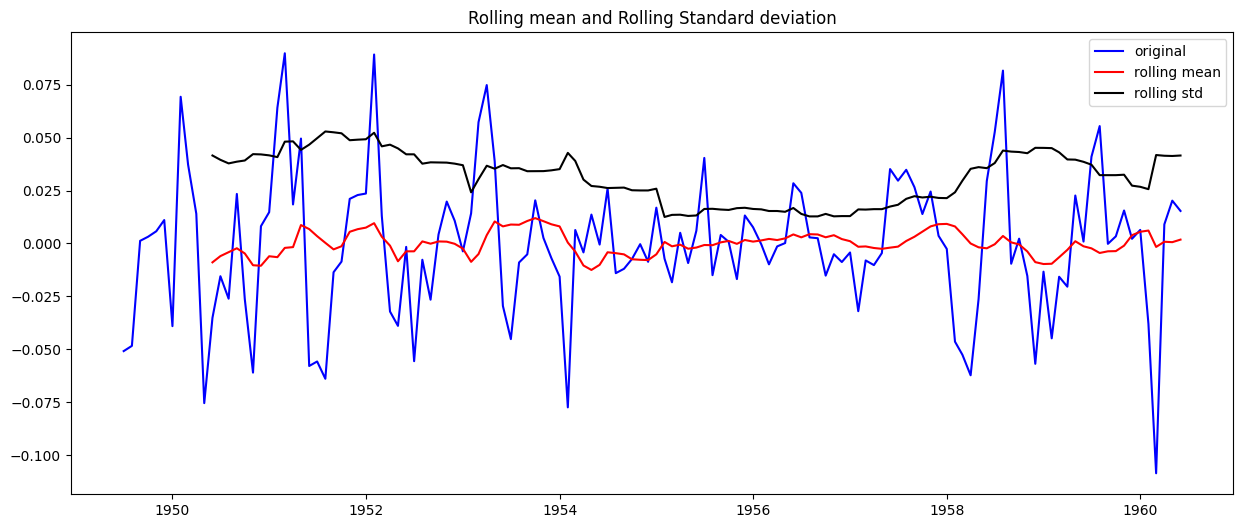

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical value (1%)           -3.485122e+00
Critical value (5%)           -2.885538e+00
Critical value (10%)          -2.579569e+00
dtype: float64


In [21]:
ts_log_decompose_residual = residual
ts_log_decompose_residual.dropna(inplace=True)
test_stationarity(residual)

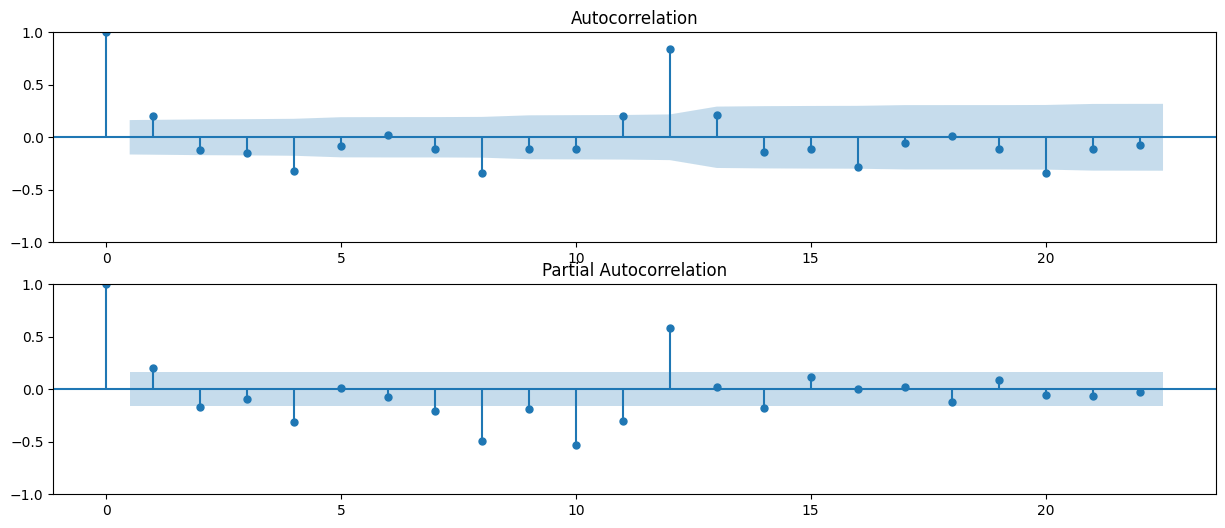

In [22]:
#Getting ready for ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

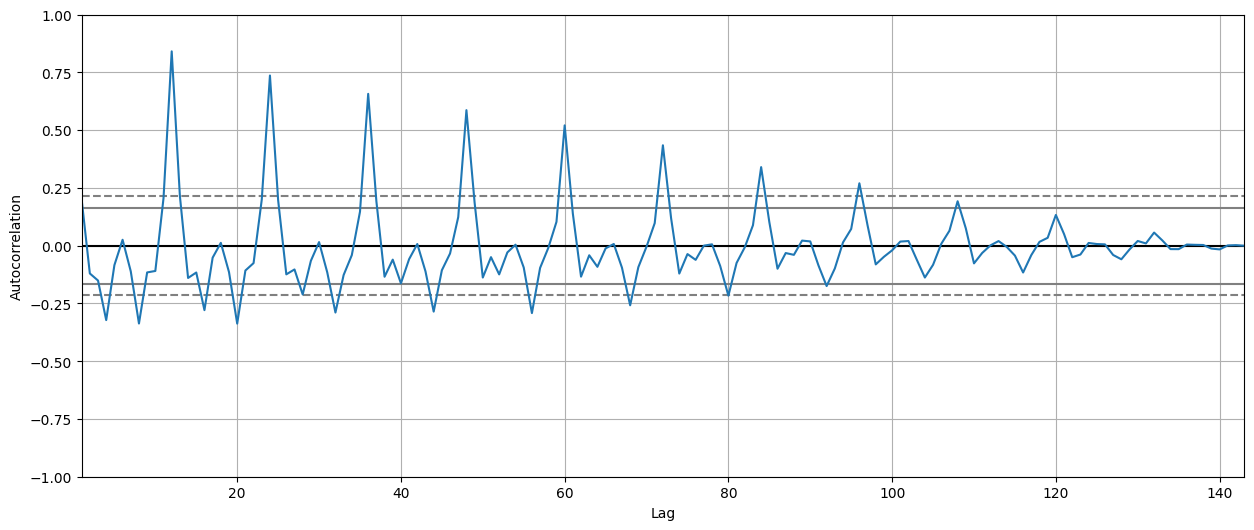

In [23]:
pd.plotting.autocorrelation_plot(ts_log_diff)

In [24]:
#Another method of ACF AND PACF
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=60)
lag_pacf = pacf(ts_log_diff, nlags=60, method='ols')

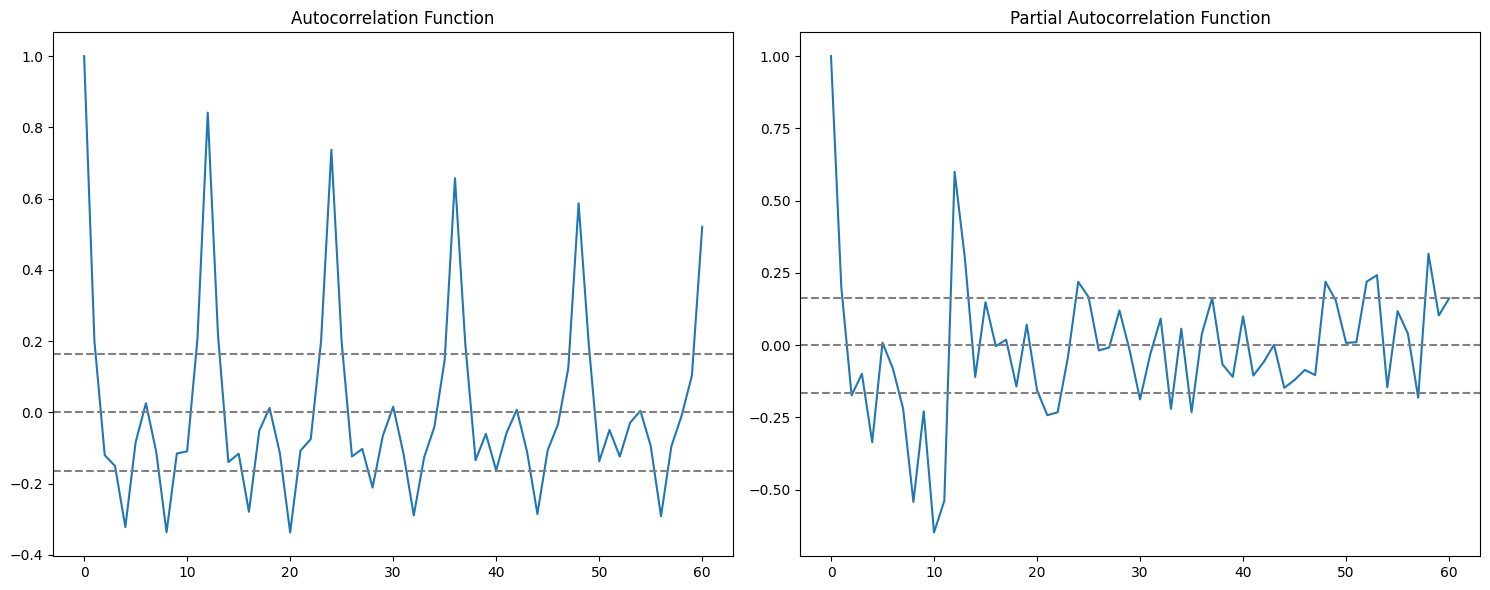

In [25]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [26]:
#Creating 3 ARIMA models

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


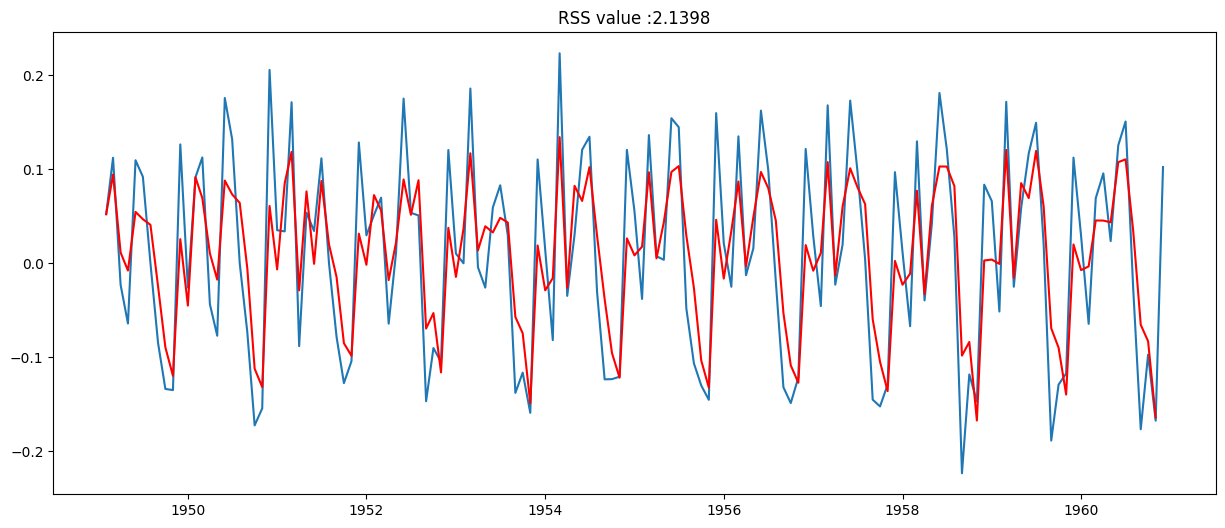

In [27]:
model = ARIMA(ts_log_diff, order=(2, 1, 0))
model_results = model.fit()
plt.plot(ts_log_diff)
plt.plot(model_results.fittedvalues.shift(periods=-1), color='red')
plt.title("RSS value :%.4f"%sum((model_results.fittedvalues - ts_log_diff)**2))
plt.show()

C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


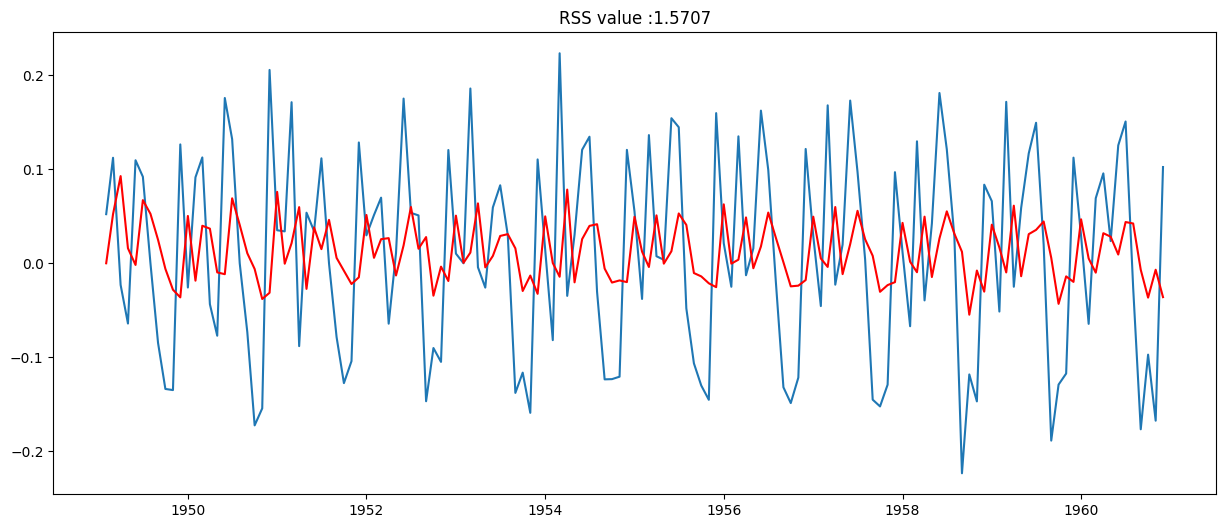

In [28]:
#Moving average model

model = ARIMA(ts_log_diff, order=(0, 1, 2))
model_results = model.fit()
plt.plot(ts_log_diff)
plt.plot(model_results.fittedvalues, color='red')
plt.title("RSS value :%.4f"%sum((model_results.fittedvalues - ts_log_diff)**2))
plt.show()

C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


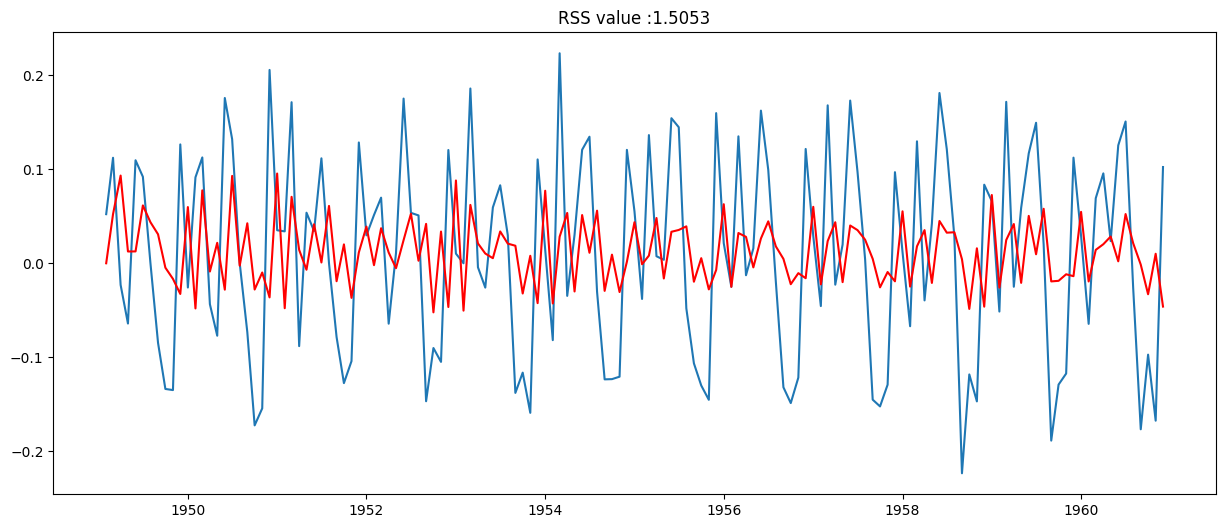

In [29]:
#combined model
model = ARIMA(ts_log_diff, order=(2, 1, 2))
model_results = model.fit()
plt.plot(ts_log_diff)
plt.plot(model_results.fittedvalues, color='red')
plt.title("RSS value :%.4f"%sum((model_results.fittedvalues - ts_log_diff)**2))
plt.show()

In [30]:
predictions_arima_diff = pd.Series(model_results.fittedvalues)

In [31]:
predictions_arima_diff.head()

Month
1949-02-01    0.000000
1949-03-01    0.052186
1949-04-01    0.093192
1949-05-01    0.012536
1949-06-01    0.012605
dtype: float64

In [32]:
predictions_arima_diff_cumsum = predictions_arima_diff.cumsum()
predictions_arima_diff_cumsum.head()

Month
1949-02-01    0.000000
1949-03-01    0.052186
1949-04-01    0.145378
1949-05-01    0.157914
1949-06-01    0.170519
dtype: float64

In [33]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_arima_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.770685
1949-04-01    4.863877
1949-05-01    4.876413
dtype: float64

Text(0.5, 1.0, 'RMSE: 105.9617')

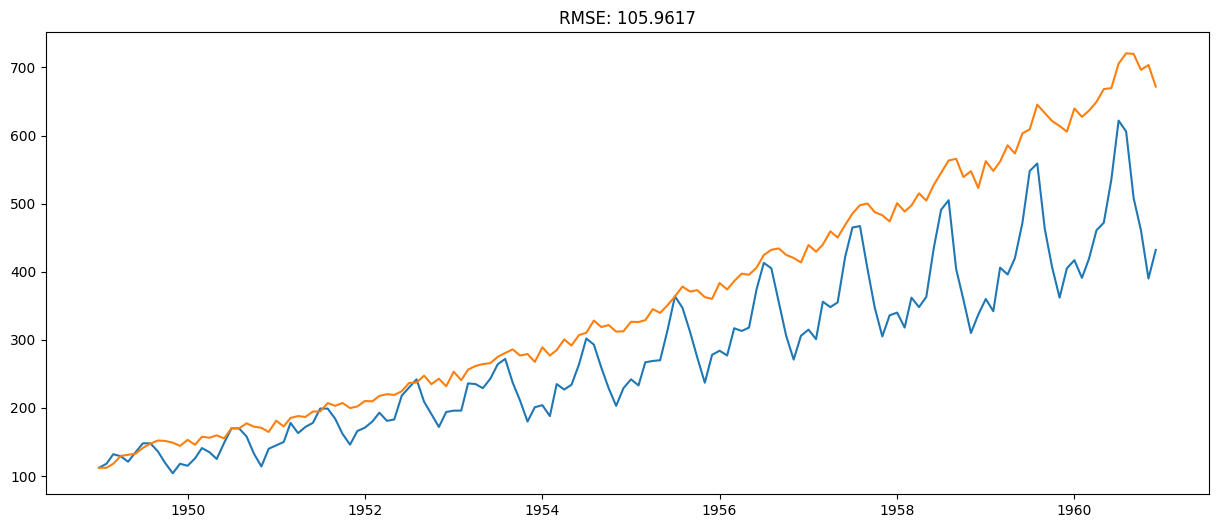

In [34]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title("RMSE: %.4f"%np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [35]:
#SARIMAX

import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
for i in seasonal_pdq:
    print(i)
print(pdq)

(0, 0, 0, 12)
(0, 0, 1, 12)
(0, 1, 0, 12)
(0, 1, 1, 12)
(1, 0, 0, 12)
(1, 0, 1, 12)
(1, 1, 0, 12)
(1, 1, 1, 12)
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [72]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
AIC_df = pd.DataFrame({"param": [], "seasonal_param": [], "AIC": []})

for param in pdq:
    print("Param: ", param)
    for seasonal_param in seasonal_pdq:
        print("Seasonal_param: ", seasonal_param)
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order=param, seasonal_order=seasonal_param, 
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            res = mod.fit()
            print("res.aic: ", res.aic)
            temp = pd.DataFrame({"param": [param], "seasonal_param": [seasonal_param], "AIC": [res.aic]})
            print("temp: ", temp)
            frames = [AIC_df, temp]
            AIC_df = pd.concat([AIC_df, temp], ignore_index=True)
            print("New AIC_df: ", AIC_df)
            del temp
        except:
            continue
    

Param:  (0, 0, 0)
Seasonal_param:  (0, 0, 0, 12)
res.aic:  898.736748684099
temp:         param seasonal_param         AIC
0  (0, 0, 0)  (0, 0, 0, 12)  898.736749
New AIC_df:         param seasonal_param         AIC
0  (0, 0, 0)  (0, 0, 0, 12)  898.736749
Seasonal_param:  (0, 0, 1, 12)
res.aic:  687.3749017314516
temp:         param seasonal_param         AIC
0  (0, 0, 0)  (0, 0, 1, 12)  687.374902
New AIC_df:         param seasonal_param         AIC
0  (0, 0, 0)  (0, 0, 0, 12)  898.736749
1  (0, 0, 0)  (0, 0, 1, 12)  687.374902
Seasonal_param:  (0, 1, 0, 12)
res.aic:  -150.62577301420643
temp:         param seasonal_param         AIC
0  (0, 0, 0)  (0, 1, 0, 12) -150.625773
New AIC_df:         param seasonal_param         AIC
0  (0, 0, 0)  (0, 0, 0, 12)  898.736749
1  (0, 0, 0)  (0, 0, 1, 12)  687.374902
2  (0, 0, 0)  (0, 1, 0, 12) -150.625773
Seasonal_param:  (0, 1, 1, 12)
res.aic:  -179.24122958004844
temp:         param seasonal_param        AIC
0  (0, 0, 0)  (0, 1, 1, 12) -179.2412

res.aic:  -296.957092122385
temp:         param seasonal_param         AIC
0  (0, 1, 0)  (0, 0, 1, 12) -296.957092
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
Seasonal_param:  (0, 1, 0, 12)
res.aic:  -431.2309178955404
temp:         param seasonal_para

res.aic:  -295.1391196742494
temp:         param seasonal_param        AIC
0  (0, 1, 1)  (0, 0, 1, 12) -295.13912
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1, 0

res.aic:  -428.8696604961369
temp:         param seasonal_param        AIC
0  (0, 1, 1)  (1, 1, 1, 12) -428.86966
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1, 0

res.aic:  -472.0082191319907
temp:         param seasonal_param         AIC
0  (1, 0, 0)  (1, 0, 1, 12) -472.008219
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1,

res.aic:  -436.9446109411788
temp:         param seasonal_param         AIC
0  (1, 0, 1)  (0, 1, 1, 12) -436.944611
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1,

res.aic:  -431.5721857067186
temp:         param seasonal_param         AIC
0  (1, 0, 1)  (1, 1, 1, 12) -431.572186
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1,

res.aic:  -437.52579324696404
temp:         param seasonal_param         AIC
0  (1, 1, 0)  (0, 1, 1, 12) -437.525793
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1

res.aic:  -429.77765857494944
temp:         param seasonal_param         AIC
0  (1, 1, 0)  (1, 1, 1, 12) -429.777659
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1

res.aic:  -433.78515547895995
temp:         param seasonal_param         AIC
0  (1, 1, 1)  (0, 1, 1, 12) -433.785155
New AIC_df:          param seasonal_param         AIC
0   (0, 0, 0)  (0, 0, 0, 12)  898.736749
1   (0, 0, 0)  (0, 0, 1, 12)  687.374902
2   (0, 0, 0)  (0, 1, 0, 12) -150.625773
3   (0, 0, 0)  (0, 1, 1, 12) -179.241230
4   (0, 0, 0)  (1, 0, 0, 12) -344.536297
5   (0, 0, 0)  (1, 0, 1, 12) -342.608919
6   (0, 0, 0)  (1, 1, 0, 12) -225.908692
7   (0, 0, 0)  (1, 1, 1, 12) -301.460457
8   (0, 0, 1)  (0, 0, 0, 12)  704.009740
9   (0, 0, 1)  (0, 0, 1, 12)  509.222473
10  (0, 0, 1)  (0, 1, 0, 12) -254.340773
11  (0, 0, 1)  (0, 1, 1, 12) -248.422318
12  (0, 0, 1)  (1, 0, 0, 12) -396.279447
13  (0, 0, 1)  (1, 0, 1, 12) -395.713723
14  (0, 0, 1)  (1, 1, 0, 12) -271.431233
15  (0, 0, 1)  (1, 1, 1, 12) -339.499279
16  (0, 1, 0)  (0, 0, 0, 12) -230.041330
17  (0, 1, 0)  (0, 0, 1, 12) -296.957092
18  (0, 1, 0)  (0, 1, 0, 12) -431.230918
19  (0, 1, 0)  (0, 1, 1, 12) -421.597681
20  (0, 1

In [73]:
# AIC_df = pd.DataFrame({"param": [], "seasonal_param": [], "AIC": []})
# print(AIC_df)
# temp = pd.DataFrame({"param": [1], "seasonal_param": [1], "AIC": [1]})
# temp1 = pd.DataFrame({"param": [1], "seasonal_param": [1], "AIC": [1]})

# AIC_df = pd.concat([AIC_df, temp, temp1], ignore_index=True)
# print("New AIC_df: \n", AIC_df)

In [75]:
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]
model = sm.tsa.statespace.SARIMAX(ts_log, order=min_aic.param, seasonal_order=min_aic.seasonal_param,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.108      0.000       0.865       1.019
ma.L1         -0.3805      0.093     -4.094      0.000      -0.563      -0.198
ar.S.L12       1.0200      0.003    302.416      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.241      0.000       0.001       0.002


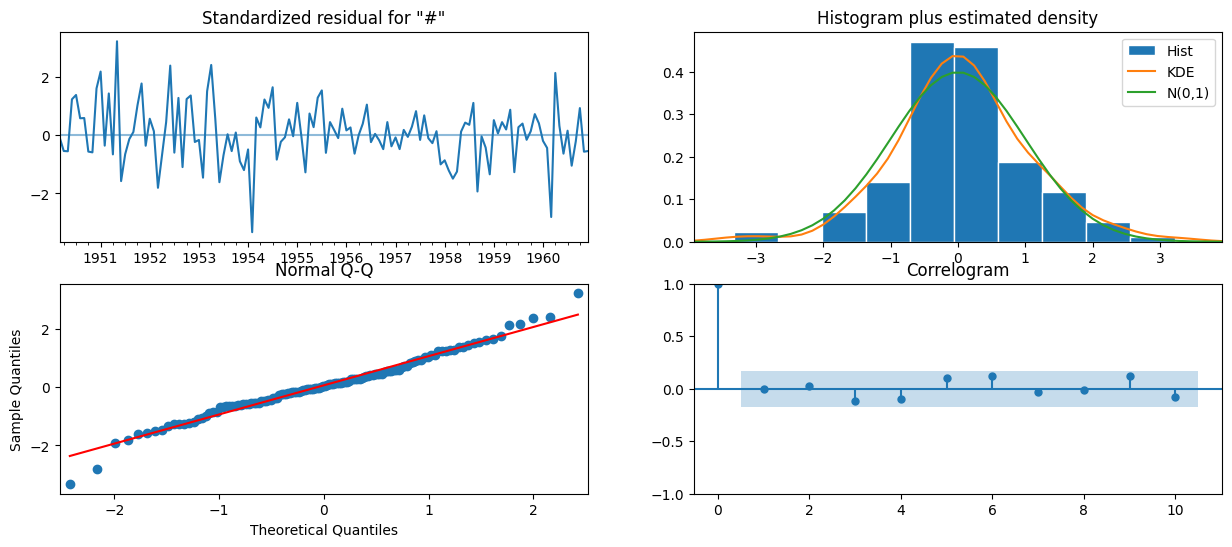

In [76]:
results.plot_diagnostics()
plt.show()